# Final Project - Shawn Feng, Will Novak, Eddie Loyd

In [6]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [92]:
#filenames = glob.glob('midi_data/*/**/*.mid', recursive=True)
#filenames = glob.glob('maestro-v3.0.0/**/*.mid*', recursive=True)
#sample_file = filenames[1]  # Change this to the desired MIDI file
#sample_file = "midi_data\progressions\I-VI-ii-V-maj\A-5-I-VI-ii-V-maj-46.mid"
#sample_file = "midi_data\scales\ionian\G-4ionian-4.mid"
sample_file = "maestro-v3.0.0\\2008\MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--3.midi"
sample_file

'maestro-v3.0.0\\2008\\MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--3.midi'

In [93]:
pm = pretty_midi.PrettyMIDI(sample_file)
print(pm)

In [94]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    _SAMPLING_RATE = 16000
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [95]:
display_audio(pm)

In [98]:
sample_file = "midi_data\scales\ionian\G-4ionian-0.mid"
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [83]:
sample_file = "midi_data\scales\ionian\G-4ionian-1.mid"
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [84]:
sample_file = "midi_data\scales\ionian\G-4ionian-2.mid"
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [85]:
sample_file = "midi_data\scales\ionian\G-4ionian-3.mid"
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [86]:
sample_file = "midi_data\scales\ionian\G-4ionian-4.mid"
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [87]:
sample_file = "midi_data\scales\ionian\G-4ionian-5.mid"
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [88]:
sample_file = "midi_data\scales\ionian\G-4ionian-6.mid"
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [48]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [99]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()
raw_notes

pitch  start  end  step  duration
0     67    0.0  1.0   0.0       1.0
1     69    1.0  2.0   1.0       1.0
2     71    2.0  3.0   1.0       1.0
3     72    3.0  4.0   1.0       1.0
4     74    4.0  5.0   1.0       1.0
5     76    5.0  6.0   1.0       1.0
6     78    6.0  7.0   1.0       1.0

In [100]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F#5'], dtype='<U3')

In [101]:
from music21 import *

In [102]:
s = corpus.parse('bach/bwv65.2.xml')

In [109]:
s.show()

SubConverterException: Cannot find a path to the 'mscore' file at C:\Users\shawn\OneDrive\Documents\DIS_ANN\Neural-Networks-Jazz\C:\Program Files\MuseScore 3\bin\MuseScore3.exe -- download MuseScore

In [51]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

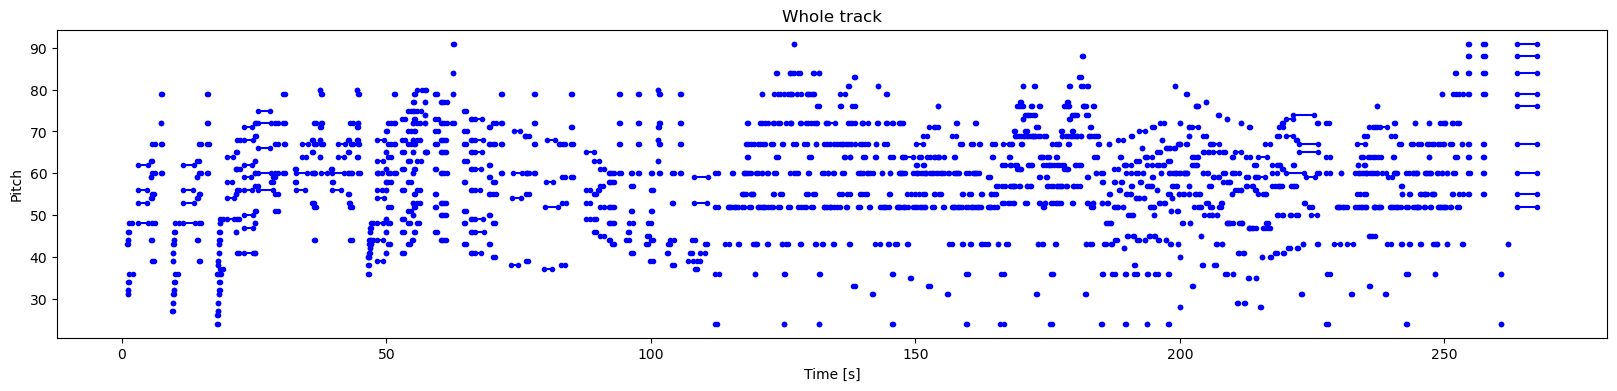

In [52]:
plot_piano_roll(raw_notes)

In [53]:
import random
random.shuffle(filenames)

In [54]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    try:
        notes = midi_to_notes(f)
        all_notes.append(notes)
    except:
        print(f)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
n_notes

28564

In [55]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
train_notes

array([[6.70000000e+01, 0.00000000e+00, 5.45572917e-01],
       [7.10000000e+01, 3.30729167e-01, 1.86197917e-01],
       [6.90000000e+01, 7.55208333e-02, 9.67447917e-01],
       ...,
       [3.00000000e+01, 3.27083333e+00, 2.14192708e+00],
       [4.20000000e+01, 1.30208333e-03, 2.14062500e+00],
       [5.40000000e+01, 6.51041667e-03, 2.13411458e+00]])

In [56]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [57]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                                drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [58]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [59]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [60]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [61]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [62]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [63]:
%%time
epochs = 25

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/25
445/445 [==============================] - 45s 64ms/step - loss: 0.4118 - duration_loss: 0.1469 - pitch_loss: 4.1509 - step_loss: 0.0573
Epoch 2/25
445/445 [==============================] - 28s 64ms/step - loss: 0.3958 - duration_loss: 0.1412 - pitch_loss: 3.9955 - step_loss: 0.0549
Epoch 3/25
445/445 [==============================] - 28s 62ms/step - loss: 0.3906 - duration_loss: 0.1405 - pitch_loss: 3.9195 - step_loss: 0.0541
Epoch 4/25
445/445 [==============================] - 28s 64ms/step - loss: 0.3871 - duration_loss: 0.1393 - pitch_loss: 3.8891 - step_loss: 0.0533
Epoch 5/25
445/445 [==============================] - 28s 62ms/step - loss: 0.3842 - duration_loss: 0.1380 - pitch_loss: 3.8671 - step_loss: 0.0529
Epoch 6/25
445/445 [==============================] - 28s 62ms/step - loss: 0.3825 - duration_loss: 0.1367 - pitch_loss: 3.8608 - step_loss: 0.0529
Epoch 7/25
445/445 [==============================] - 28s 63ms/step - loss: 0.3785 - duration_loss: 0.1345 - pit

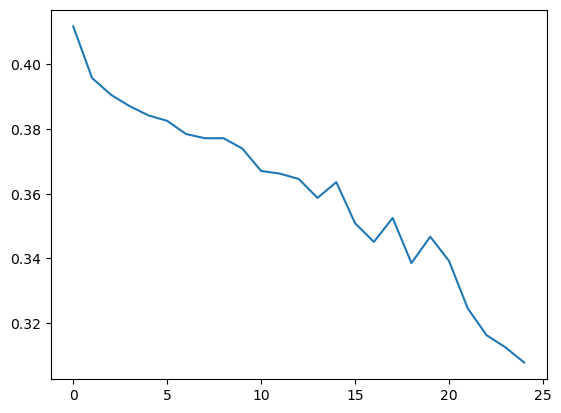

In [64]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [65]:
def predict_next_note(
        notes: np.ndarray, 
        model: tf.keras.Model, 
        temperature: float = 1.0) -> tuple[int, float, float]:
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [66]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

In [67]:
input_notes.shape

(25, 3)

In [68]:
generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
        generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 60ms/step


In [69]:
generated_notes.head(10)

pitch      step  duration     start       end
0     45  0.115596  0.264098  0.115596  0.379694
1     50  0.093475  1.085430  0.209072  1.294501
2     78  0.133389  1.194077  0.342461  1.536538
3     83  0.000000  1.148781  0.342461  1.491242
4     49  0.024428  1.118716  0.366889  1.485606
5     49  0.140223  1.182019  0.507113  1.689132
6     67  0.052832  1.186806  0.559945  1.746751
7     74  0.012895  1.158058  0.572840  1.730898
8     70  0.027028  1.148602  0.599868  1.748470
9     42  0.052568  1.159265  0.652436  1.811701

In [70]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str, 
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [71]:
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
instrument_name

'Acoustic Grand Piano'

In [72]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

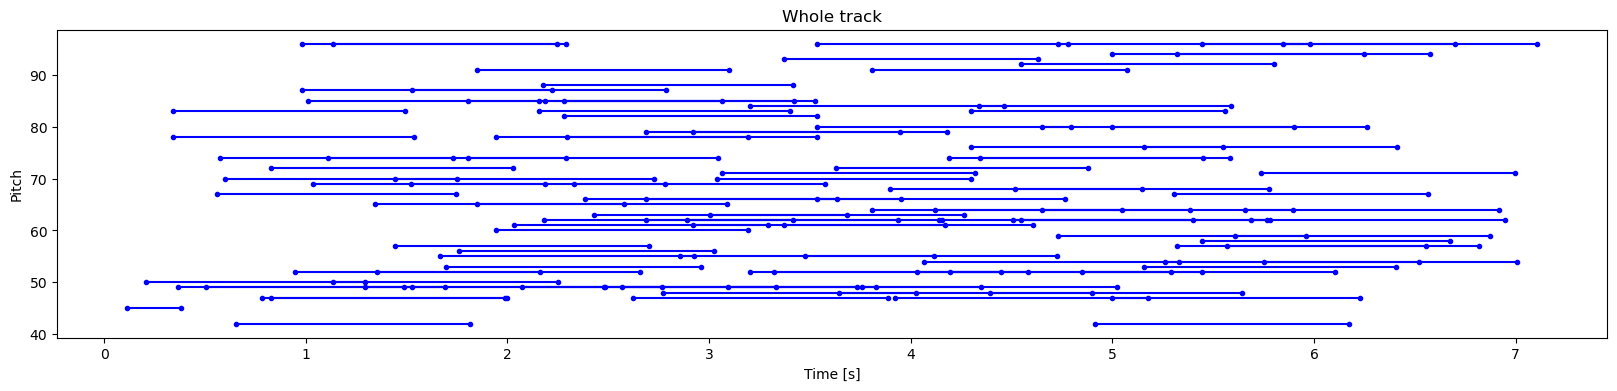

In [73]:
plot_piano_roll(generated_notes)

In [74]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

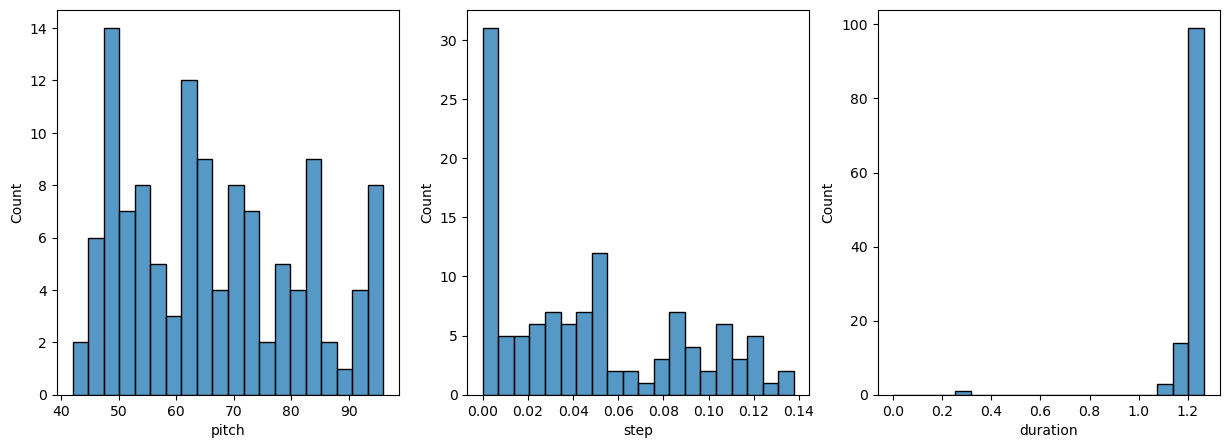

In [75]:
plot_distributions(generated_notes)